## Bayesian Optimisation 1-Dimensional function

In this notebook, we will use **Bayesian Optimization** to find the best number of estimators for a Gradient Boosting Machine. That is, we will optimize the number of trees for our ensemble.

Because we are optimizing only 1 hyperparameter, the number of trees, our hyperparameter response function is **1 dimensional** so we can compare the procedure to what we saw in the previous, theoretical videos.

This is a demo notebook, to further understand the procedure of Bayesian Optimization, utilizing code and plots.

We will use the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html)

### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
)

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_gaussian_process
from skopt.space import Integer
from skopt.utils import use_named_args

In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0: 1, 1: 0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Determine the hyperparameter response function 

We are going to map the hyperparameter response function for 1 parameter: the number of estimators. This way, we have a 1-dimensional function that we can use to relate to the theoretical videos we discussed throughout this section.

In [5]:
# set up the model
gbm = GradientBoostingClassifier(random_state=0)

# determine the hyperparameter space
param_grid = {
    'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250, 300],
}

# set up the search
search = GridSearchCV(gbm, param_grid, scoring='accuracy', cv=3, refit=False)

# find best hyperparameter
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250,
                                          300]},
             refit=False, scoring='accuracy')

In [6]:
results = pd.DataFrame(search.cv_results_)

results.sort_values(by='param_n_estimators', ascending=False, inplace=True)

results[['param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
8,300,0.952286,0.014111
7,250,0.952286,0.014111
6,200,0.952286,0.014111
5,150,0.949780,0.012687
4,120,0.949761,0.012736
3,100,0.947236,0.012280
2,50,0.942223,0.018721
1,20,0.934685,0.012722
0,10,0.937210,0.009236


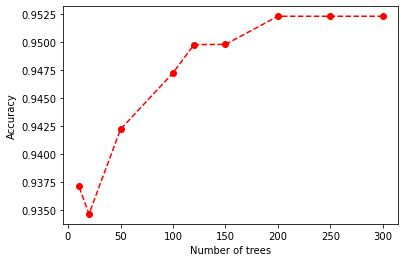

In [7]:
# plot f(x) - 1-D hyperparameter response function

plt.plot(results['param_n_estimators'], results['mean_test_score'], "ro--")

plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

In [8]:
search.best_params_

{'n_estimators': 200}

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [9]:
# With Integer, we create a space of integers, sampled uniformly
# between the minimum and maximum indicated values

Integer(10, 300, name="n_estimators")

Integer(low=10, high=300, prior='uniform', transform='identity')

In [10]:
# specify the hyperparameter space

param_grid = [Integer(10, 300, name="n_estimators")]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

In [11]:
param_grid 

[Integer(low=10, high=300, prior='uniform', transform='identity')]

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [12]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate metric because we need to minimize
    return -value

## Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

[gp_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)

### Note

At the time of running this notebook, Scikit-Optimize was incompatible with version 1.6.0 from Scipy. So if you are getting the following error:


>c:\users\sole\documents\repositories\envs\html\lib\site-packages\sklearn\utils\optimize.py in _check_optimize_result(solver, result, max_iter, extra_warning_msg)
    241                 "    https://scikit-learn.org/stable/modules/"
    242                 "preprocessing.html"
--> 243             ).format(solver, result.status, result.message.decode("latin1"))
    244             if extra_warning_msg is not None:
    245                 warning_msg += "\n" + extra_warning_msg

>AttributeError: 'str' object has no attribute 'decode'


**Consider installing Scipy version 1.5.3**


https://github.com/scikit-optimize/scikit-optimize/issues/981

In [13]:
# gp_minimize performs by default GP Optimization

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=2, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=20, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

/home/bk/anaconda3/envs/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/bk/anaconda3/envs/py38/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [14]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9523'

In [15]:
print("""Best parameters:
=========================
- n_estimators=%d""" % (gp_.x[0]))

Best parameters:
- n_estimators=255


## Evaluate convergence of the search

This plot let's us visualize if the Bayesian Optimization has found the minimum of the response function.

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

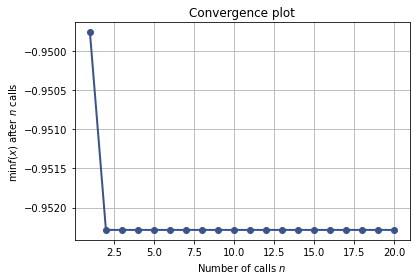

In [16]:
plot_convergence(gp_)

From the plot above, we see that the search found the optimum pretty much on the examination of the second point!!

## Plot Bayesian Optimization Search

[plot_gaussian_process](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_gaussian_process.html#skopt.plots.plot_gaussian_process)

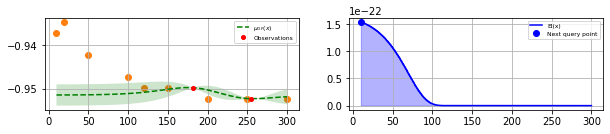

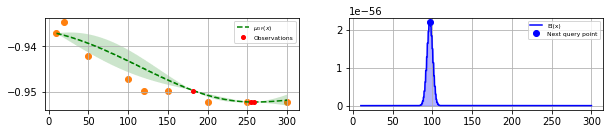

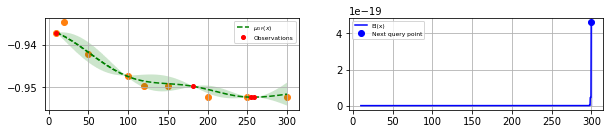

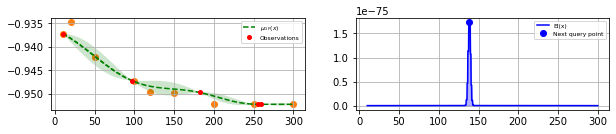

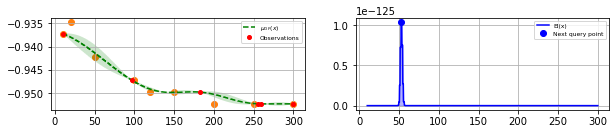

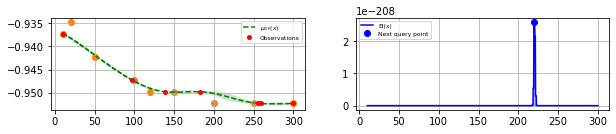

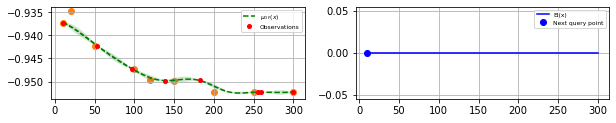

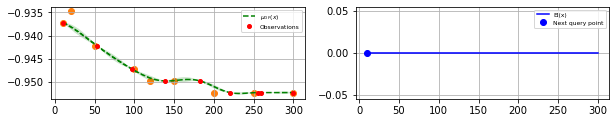

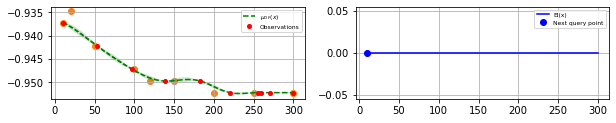

In [17]:
end = 10

for n_iter in range(1, end):
    
    # figure size
    plt.figure(figsize=(10,20))
    
    # ===================
    
    # 2 plots next to each other, left plot
    plt.subplot(end, 2, 2*n_iter+1)

    # plot gaussian process search
    ax = plot_gaussian_process(
        gp_,
        n_calls=n_iter,
        show_legend=True,
        show_title=False,
        show_next_point=False,
        show_acq_func=False)
    
    # plot true hyperparameter response function
    ax.scatter(results['param_n_estimators'], -results['mean_test_score'])

    ax.set_ylabel("")
    ax.set_xlabel("")
    
    # ===================
    
    # Plot EI(x) - the acquisition function
    
    # 2 plots next to each other, right plot
    plt.subplot(end, 2, 2*n_iter+2)
    
    ax = plot_gaussian_process(
        gp_,
        n_calls=n_iter,
        show_legend=True,
        show_title=False,
        show_mu=False,
        show_acq_func=True,
        show_observations=False,
        show_next_point=True)
    
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()